# Zipf’s Law of Abbreviation in Bukowski: English vs Spanish

This notebook investigates whether **Zipf’s Law of Abbreviation** holds for a poem by Charles Bukowski in English and its Spanish translation.

Zipf’s Law of Abbreviation predicts that **more frequent linguistic units tend to be shorter**.  
We test this hypothesis using four methodological variants:

1. Lemmas with stopwords  
2. Lemmas without stopwords  
3. Surface word forms with stopwords  
4. Surface word forms without stopwords  

The analysis is conducted using **spaCy** for linguistic preprocessing and **Spearman’s rank correlation** for statistical testing.


## Dependencies and environment

This notebook runs with the following environment:

- Python 3.10.19
- spaCy 3.8.11
- pandas 2.3.3
- matplotlib 3.10.8
- SciPy 1.15.3

spaCy language models:
- en_core_web_sm (spaCy 3.8.0)
- es_core_news_sm (spaCy 3.8.0)

The analysis is executed in a Conda environment.


## 1. Imports and setup

We begin by importing the necessary Python libraries.

- **spaCy** is used for tokenization, lemmatization, and stopword detection.
- **pandas** is used to store and manipulate frequency–length data.
- **matplotlib** is used for visualization.
- **SciPy** provides Spearman’s rank correlation coefficient, which is appropriate for Zipfian distributions.


In [4]:
import sys
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

## 2. Loading spaCy language models

Separate spaCy pipelines are required for English and Spanish because the two languages differ in morphology, stopword inventories, and lemmatization rules.

In [5]:
nlp_en = spacy.load("en_core_web_sm")
nlp_es = spacy.load("es_core_news_sm")

## 3. Loading the texts

The English poem and its Spanish translation are loaded from UTF-8 encoded text files.  
Using UTF-8 ensures that accented characters (e.g. ñ, á, é) are read correctly.


In [6]:
with open("Bukowski_en_drinking.txt", "r", encoding="utf-8") as f:
    text_en = f.read()

with open("Bukowski_es_beber.txt", "r", encoding="utf-8") as f:
    text_es = f.read()

## 4. Computing word statistics

We define a function that:
1. Tokenizes the text using spaCy
2. Optionally lemmatizes tokens
3. Optionally removes stopwords
4. Counts the frequency of each unit
5. Measures its length in characters

This function allows us to flexibly test different methodological choices.


In [7]:
def get_stats(text, nlp, use_lemma=True, remove_stopwords=False):
    """
    Compute frequency and length statistics for a text.

    Parameters
    ----------
    text : str
        Raw text input.
    nlp : spacy.Language
        spaCy language pipeline.
    use_lemma : bool
        If True, use lemmas instead of surface forms.
    remove_stopwords : bool
        If True, exclude stopwords from the analysis.

    Returns
    -------
    pandas.DataFrame
        A table with columns: form, freq, length.
    """

    # Process the text with spaCy
    doc = nlp(text)

    # Dictionary to store frequencies
    freq = {}

    # Iterate over all tokens
    for token in doc:

        # Exclude punctuation and whitespace
        if token.is_punct or token.is_space:
            continue

        # Optionally exclude stopwords
        if remove_stopwords and token.is_stop:
            continue

        # Choose representation: lemma or surface form
        if use_lemma:
            form = token.lemma_.lower() #Lowercase to merge case variants
        else:
            form = token.text.lower()

        # Update frequency count
        if form:
            freq[form] = freq.get(form, 0) + 1

    # Convert frequency dictionary into a DataFrame
    data = []
    for form, f in freq.items():
        length = len(form)
        data.append((form, f, length))

    df = pd.DataFrame(data, columns=["form", "freq", "length"])
    return df

## 5. Testing Zipf’s Law of Abbreviation

To test Zipf’s Law, we measure the relationship between:
- **frequency** of a linguistic unit
- **length** of that unit

We use **Spearman’s rank correlation (ρ)** because:
- Zipfian data is non-linear
- Frequency distributions are highly skewed
- Spearman’s ρ operates on ranks rather than raw values

A **negative correlation** supports Zipf’s Law of Abbreviation.


In [8]:
def plot_zipf(df, title):
    """
    Plot frequency vs length and compute Spearman correlation.
    """

    # Compute Spearman correlation: non-parametric rank correlation
    rho, p = spearmanr(df["freq"], df["length"])

    # Create a new figure
    plt.figure()

    # Scatter plot with transparency (alpha) to reduce overlapping points
    plt.scatter(df["freq"], df["length"], alpha=0.6)

    # Log scale for frequency (Zipfian distribution are highly skewed and makes visualization easier)
    plt.xscale("log")

    # Axis labels
    plt.xlabel("Frequency (log scale)")
    plt.ylabel("Length (characters)")

    # Title with statistical results
    plt.title(f"{title}\nSpearman rho = {rho:.3f}, p = {p:.4f}")

    plt.show()

    return rho, p

## 6. Running all methodological variants

We test four configurations for each language:
1. Lemmas with stopwords
2. Lemmas without stopwords
3. Surface forms with stopwords
4. Surface forms without stopwords

This allows us to assess how morphological variation and function words affect Zipf’s Law.


In [9]:
def run_all(text, nlp, language_label):
    results = {}
    
    # Define all configurations
    configurations = [
        ("lemma_with_stopwords", True, False),
        ("lemma_no_stopwords", True, True),
        ("surface_with_stopwords", False, False),
        ("surface_no_stopwords", False, True),
    ]

    for name, use_lemma, remove_stopwords in configurations: # Run each configuration
        df = get_stats(text, nlp, use_lemma, remove_stopwords) # Compute frequency and length table
        title = f"{language_label} – {name.replace('_', ' ')}" # Prepare title for plotting
        rho, p = plot_zipf(df, title) # Plot and compute Spearman correlation
        results[name] = (rho, p) # Store results

    return results

## 7. Results

We now run the analysis for English and Spanish and summarize the correlation coefficients and p-values.


ENGLISH RESULTS


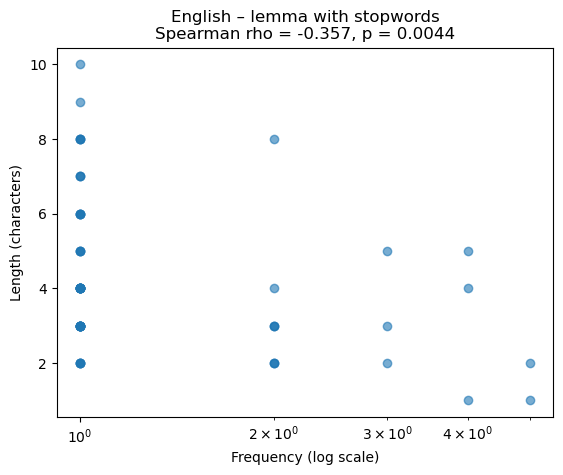

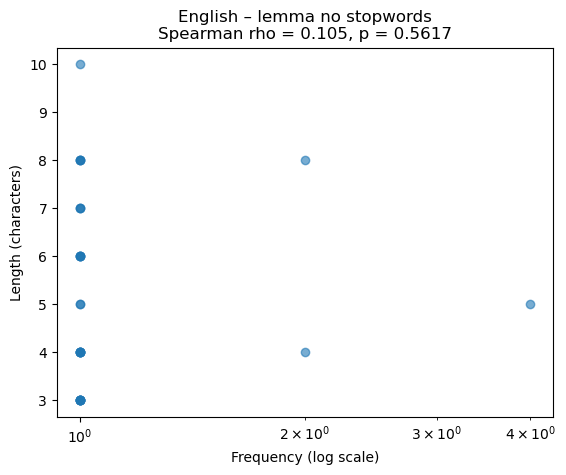

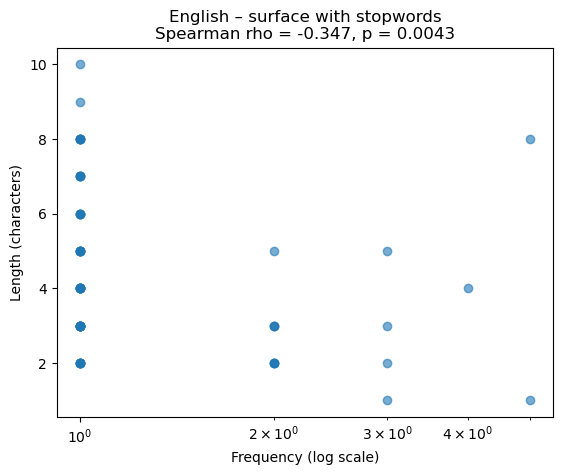

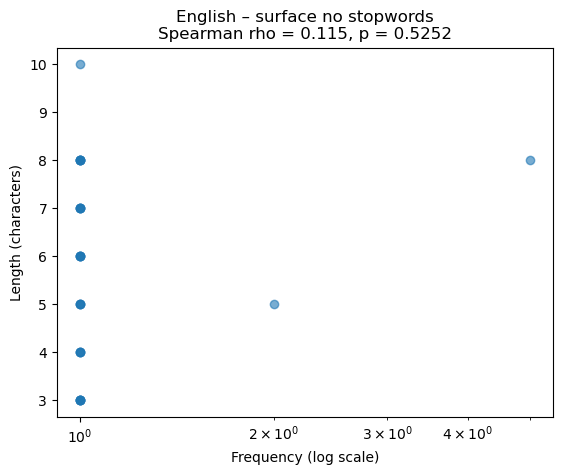


SPANISH RESULTS


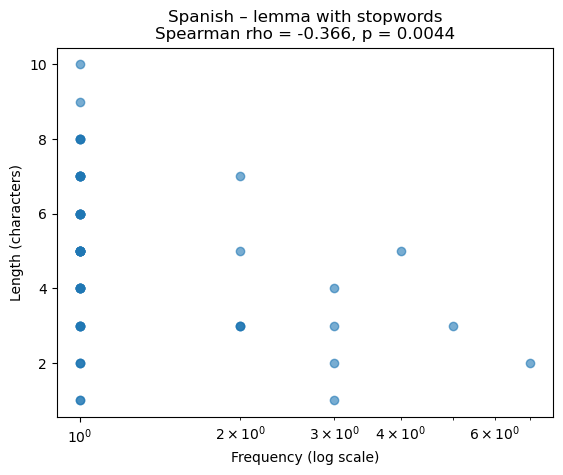

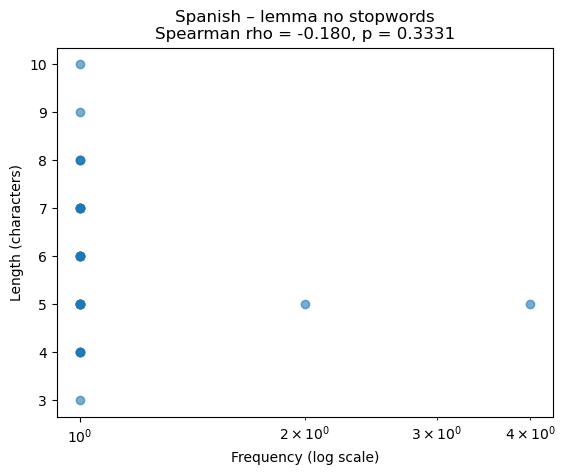

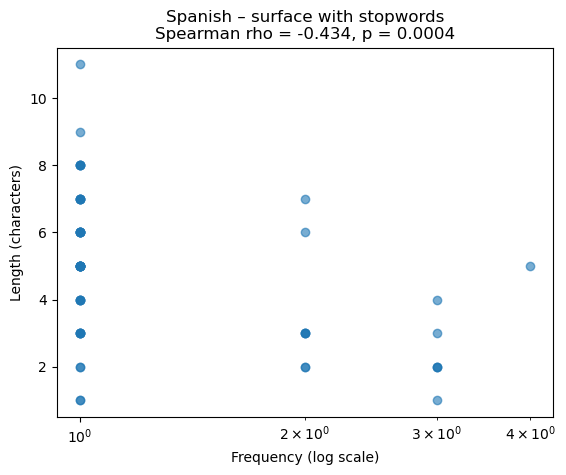

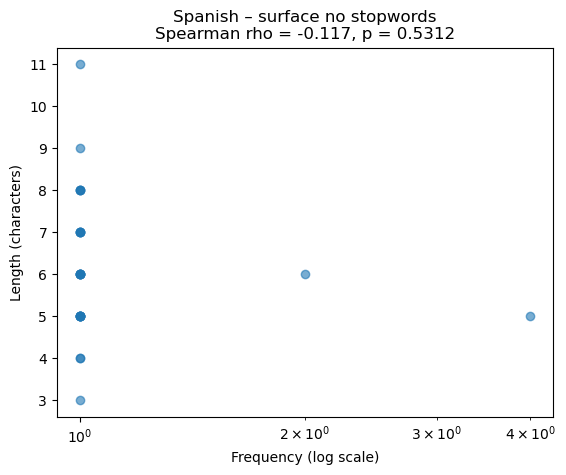


SUMMARY

English:
lemma_with_stopwords: rho=-0.357, p=0.0044
lemma_no_stopwords: rho=0.105, p=0.5617
surface_with_stopwords: rho=-0.347, p=0.0043
surface_no_stopwords: rho=0.115, p=0.5252

Spanish:
lemma_with_stopwords: rho=-0.366, p=0.0044
lemma_no_stopwords: rho=-0.180, p=0.3331
surface_with_stopwords: rho=-0.434, p=0.0004
surface_no_stopwords: rho=-0.117, p=0.5312


In [10]:
print("ENGLISH RESULTS")
results_en = run_all(text_en, nlp_en, "English")

print("\nSPANISH RESULTS")
results_es = run_all(text_es, nlp_es, "Spanish")

print("\nSUMMARY")

print("\nEnglish:")
for k, v in results_en.items():
    # Format rho and o-value for easy reading
    print(f"{k}: rho={v[0]:.3f}, p={v[1]:.4f}")

print("\nSpanish:")
for k, v in results_es.items():
    print(f"{k}: rho={v[0]:.3f}, p={v[1]:.4f}")

## 8. Interpretation

Negative and statistically significant correlations support Zipf’s Law of Abbreviation.  
Differences between lemma-based and surface-form analyses reflect the role of morphology and actual word usage.  

Differences between English and Spanish may arise from:
- morphological richness
- translation effects
- stylistic choices in poetry

Overall, the results show that Zipfian tendencies can be observed even in short literary texts, though the strength of the effect depends on methodological choices.
